<a id="2"></a>
# Modeling the Results of Pulls for MR Shards Using Monte Carlo Simulations
Credit to **VoidTwo** (_voidtwo on Discord_) for writing the code<br>
Report written by Nillabutt<br>
February 8, 2024

[*jump to the tables*](#1)

In [46]:
# Future imports
from __future__ import annotations

# Standard imports
from collections import defaultdict
from multiprocessing.pool import Pool as mp_Pool
from secrets import randbelow as secrets_randbelow
from typing import TYPE_CHECKING

# 3rd party imports
from matplotlib import pyplot as plt
import pandas as pd

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

In [2]:
# Type checking
if TYPE_CHECKING:
    from typing import (
        ClassVar,
        Final)

    from matplotlib.axes import Axes

In [3]:
class SummonInfo:
    shard_probability_range: ClassVar[int] = 100_000
    shard_probability_threshold: ClassVar[dict[int, int]] = {
        1: 23_841,  # 23.841%
        2: 31_126,  # 7.285%
        5: 33_775}  # 2.649%
    shard_probability_order: ClassVar[tuple[int, ...]] = (
        1, 2, 5)

    shard_pities: ClassVar[dict[int, int]] = {
        1: 6,
        2: 16,
        5: 65}
    shard_pity_floors: ClassVar[dict[int, int]] = {
        1: 6,
        2: 15,
        5: 58}
    shard_pity_priority: ClassVar[tuple[int, ...]] = (
        5, 2, 1)

    shard_goal: ClassVar[int] = 270

    __slots__: tuple[str, ...] = ()

    def __init__(self) -> None:
        return


class SummonProgress:
    __slots__: tuple[str, ...] = (
        '__pity_counts',
        '__accumulated_shards')

    def __init__(self) -> None:
        shard_count: int
        self.__pity_counts: Final[dict[int, int]] = dict(
            (shard_count, 1) for shard_count in SummonInfo.shard_pity_priority)
        self.__accumulated_shards: int = 0
        return

    def __str__(self) -> str:
        return (
            f'__pity_counts: {self.__pity_counts}\n'
            f'__accumulated_shards: {self.__accumulated_shards}')

    @property
    def accumulated_shards(self) -> int:
        return self.__accumulated_shards

    def add_shards(self, shard_count: int) -> None:
        self.__accumulated_shards += shard_count
        return

    def get_pity_count(self, shard_count: int) -> int:
        return self.__pity_counts[shard_count]

    def add_pity(self, shard_count: int) -> None:
        self.__pity_counts[shard_count] += 1
        return

    def reset_pity(self, shard_count: int) -> None:
        self.__pity_counts[shard_count] = 1
        return

In [4]:
def simulate_summon(summon_progress: SummonProgress) -> None:
    add_shards: int = 0
    shard_count: int

    for shard_count in SummonInfo.shard_pity_priority:
        if summon_progress.get_pity_count(shard_count) >= SummonInfo.shard_pities[shard_count]:
            summon_progress.reset_pity(shard_count)
            add_shards = shard_count
            break

    if add_shards == 0:
        random_value: int = secrets_randbelow(SummonInfo.shard_probability_range)
        threshold_expired: bool = False

        for shard_count in SummonInfo.shard_probability_order:
            if add_shards == 0 \
                    and not threshold_expired \
                    and random_value < SummonInfo.shard_probability_threshold[shard_count]:
                threshold_expired = True

                if summon_progress.get_pity_count(shard_count) >= SummonInfo.shard_pity_floors[shard_count]:
                    summon_progress.reset_pity(shard_count)
                    add_shards = shard_count
                    continue

            summon_progress.add_pity(shard_count)
    else:
        for shard_count in SummonInfo.shard_pity_priority:
            if shard_count != add_shards:
                summon_progress.add_pity(shard_count)

    summon_progress.add_shards(add_shards)
    return

In [5]:
def fully_summon(_: int) -> int:
    summon_progress: SummonProgress = SummonProgress()
    summon_count: int = 0

    while summon_progress.accumulated_shards < SummonInfo.shard_goal:
        simulate_summon(summon_progress)
        summon_count += 1
        # print(f'Summon #{summon_count}: {summon_progress.accumulated_shards}')
    return summon_count

In [77]:
def blues(target) -> None:
    SummonInfo.shard_goal = target
    iterations: Final[int] = 20000
    results: defaultdict = defaultdict(int)
    pool: mp_Pool
    summon_count: int

    for summon_count in map(fully_summon, range(iterations)):
        results[summon_count] += 1

    result_summon_counts: list[int] = []
    result_summon_count_counts: list[int] = []
    summon_count_count: int

    for summon_count, summon_count_count in sorted(results.items()):
        result_summon_counts.append(summon_count)
        result_summon_count_counts.append(summon_count_count)

    results_df: DataFrame = pd.DataFrame({'Blue Scrolls': result_summon_counts, 'Likelihood': result_summon_count_counts})
    result_ax: Axes = results_df.plot.bar(x='Blue Scrolls', y='Likelihood')
    plt.title(f"Scrolls for {target} Shards: Monte Carlo Sim of {iterations} Runs")
    plt.show()
    print(results_df)
    blue_max = results_df["Blue Scrolls"].max()
    blue_min = results_df["Blue Scrolls"].min()
    results_df["Weighted"] = results_df["Likelihood"] * results_df["Blue Scrolls"]
    average_blues = results_df["Weighted"].sum() / iterations
    blue_freq_max = results_df["Likelihood"].max()
    blue_mode = results_df.loc[results_df["Likelihood"] == blue_freq_max, "Blue Scrolls"].iloc[0]
    print(F"Iterations: {iterations}")
    print(f"Min:  {blue_min} blues")
    print(f"Max:  {blue_max} blues")
    print(f"Mean: {average_blues} blues")
    print(f"Mode: {blue_mode} blues")
    return

<a id="1"></a>
# Running the Simulations (20,000 iterations)

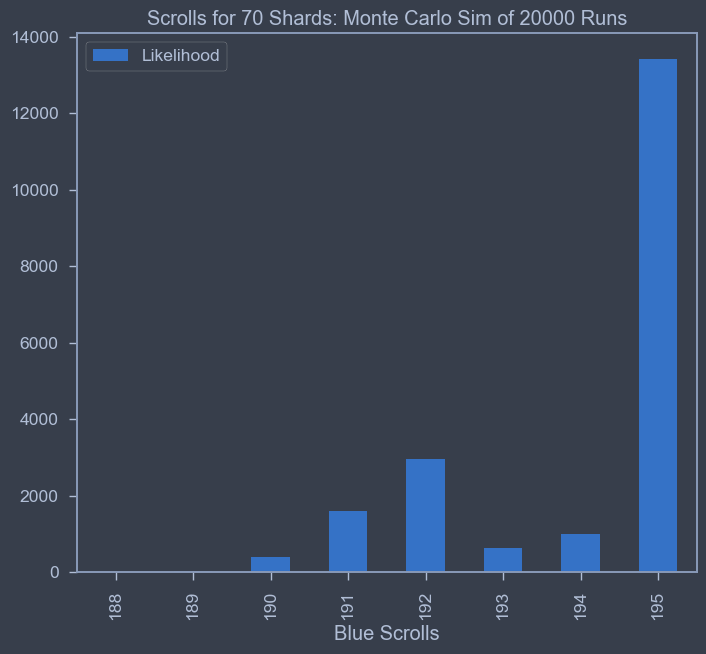

   Blue Scrolls  Likelihood
0           188           2
1           189          39
2           190         387
3           191        1587
4           192        2946
5           193         620
6           194         994
7           195       13425
Iterations: 20000
Min:  188 blues
Max:  195 blues
Mean: 194.01985 blues
Mode: 195 blues


In [78]:
# Blues for 70 shards (0 star)
blues(70)

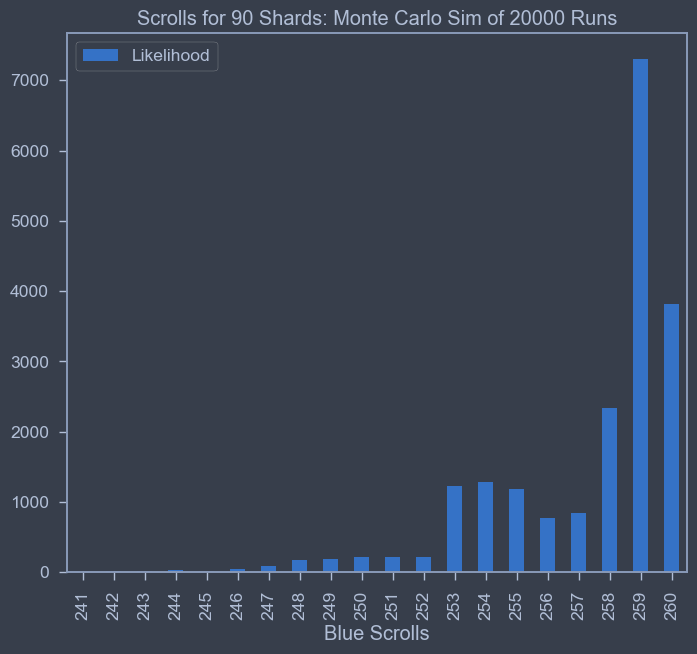

    Blue Scrolls  Likelihood
0            241           3
1            242          13
2            243          14
3            244          24
4            245          14
5            246          51
6            247          90
7            248         171
8            249         191
9            250         220
10           251         219
11           252         216
12           253        1228
13           254        1288
14           255        1188
15           256         773
16           257         843
17           258        2329
18           259        7305
19           260        3820
Iterations: 20000
Min:  241 blues
Max:  260 blues
Mean: 257.35465 blues
Mode: 259 blues


In [79]:
# Blues for 90 shards (1 star)
blues(90)

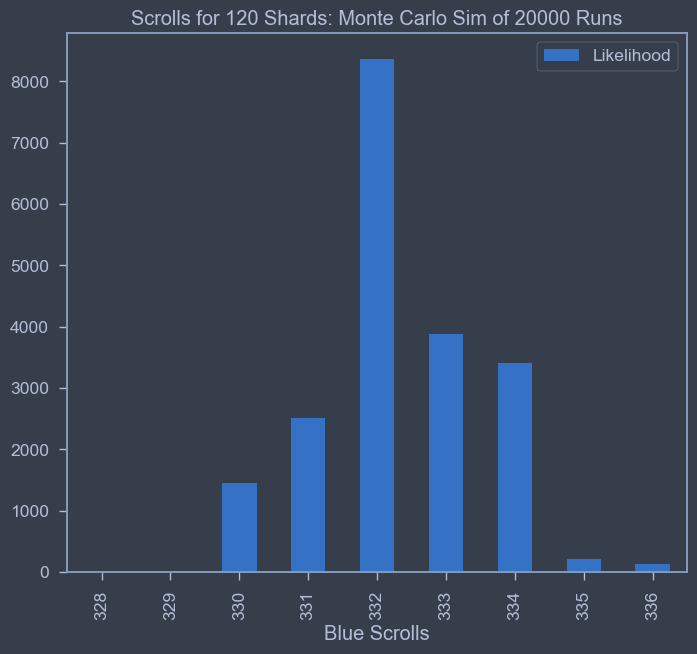

   Blue Scrolls  Likelihood
0           328           1
1           329           1
2           330        1461
3           331        2510
4           332        8370
5           333        3889
6           334        3418
7           335         212
8           336         138
Iterations: 20000
Min:  328 blues
Max:  336 blues
Mean: 332.3237 blues
Mode: 332 blues


In [80]:
# Blues for 120 shards (2 star)
blues(120)

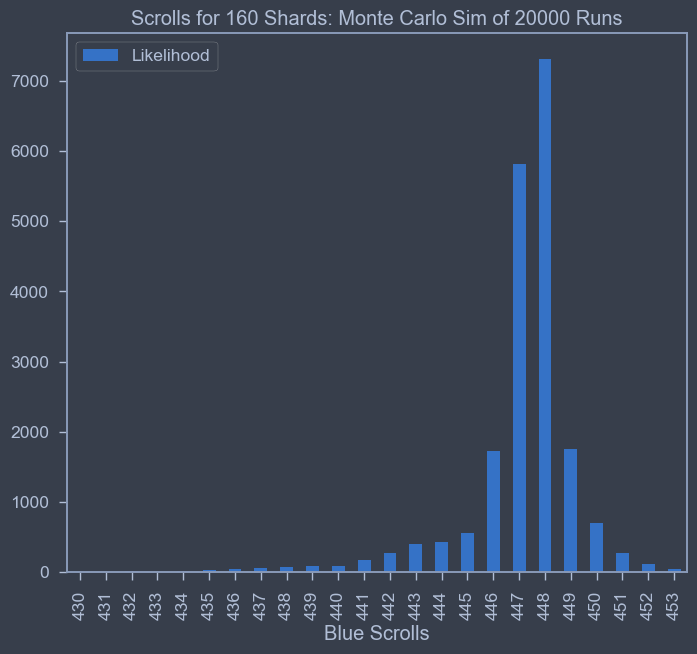

    Blue Scrolls  Likelihood
0            430           3
1            431           4
2            432          10
3            433           4
4            434          15
5            435          25
6            436          43
7            437          63
8            438          78
9            439          87
10           440          84
11           441         168
12           442         279
13           443         404
14           444         435
15           445         551
16           446        1725
17           447        5819
18           448        7315
19           449        1754
20           450         703
21           451         274
22           452         112
23           453          45
Iterations: 20000
Min:  430 blues
Max:  453 blues
Mean: 447.1401 blues
Mode: 448 blues


In [81]:
# Blues for 160 shards (3 star)
blues(160)

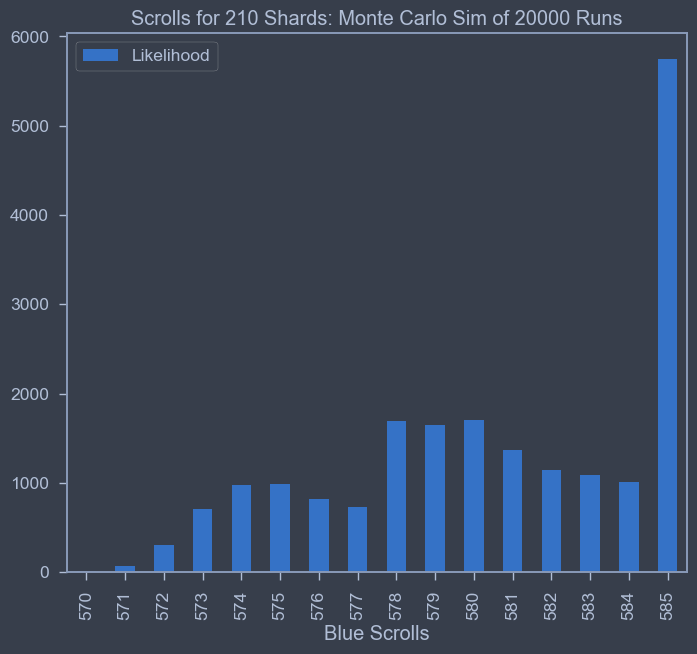

    Blue Scrolls  Likelihood
0            570          10
1            571          68
2            572         305
3            573         706
4            574         975
5            575         987
6            576         817
7            577         732
8            578        1698
9            579        1646
10           580        1703
11           581        1371
12           582        1140
13           583        1083
14           584        1010
15           585        5749
Iterations: 20000
Min:  570 blues
Max:  585 blues
Mean: 580.515 blues
Mode: 585 blues


In [82]:
# Blues for 210 shards (4 star)
blues(210)

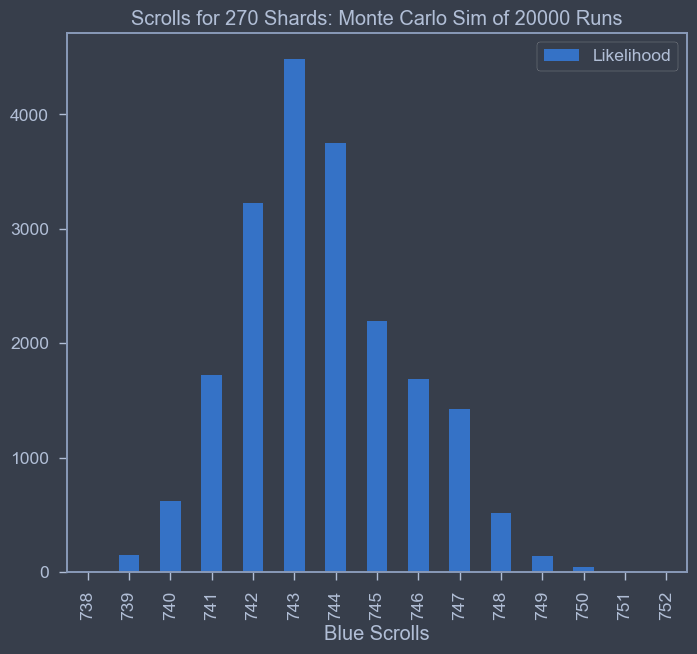

    Blue Scrolls  Likelihood
0            738           7
1            739         147
2            740         626
3            741        1724
4            742        3225
5            743        4486
6            744        3754
7            745        2198
8            746        1690
9            747        1427
10           748         517
11           749         144
12           750          47
13           751           6
14           752           2
Iterations: 20000
Min:  738 blues
Max:  752 blues
Mean: 743.6799 blues
Mode: 743 blues


In [83]:
# Blues for 270 shards (5 star)
blues(270)

[*Back to Top*](#2)